In [2]:
!pip install einops

In [124]:
import torch
import torch.nn as nn 
from einops import rearrange, repeat
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [125]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:14<00:00, 1802569.78it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 150645.30it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 2203776.28it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5149601.00it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [136]:
image,label= training_data[0]
image.shape

torch.Size([1, 28, 28])

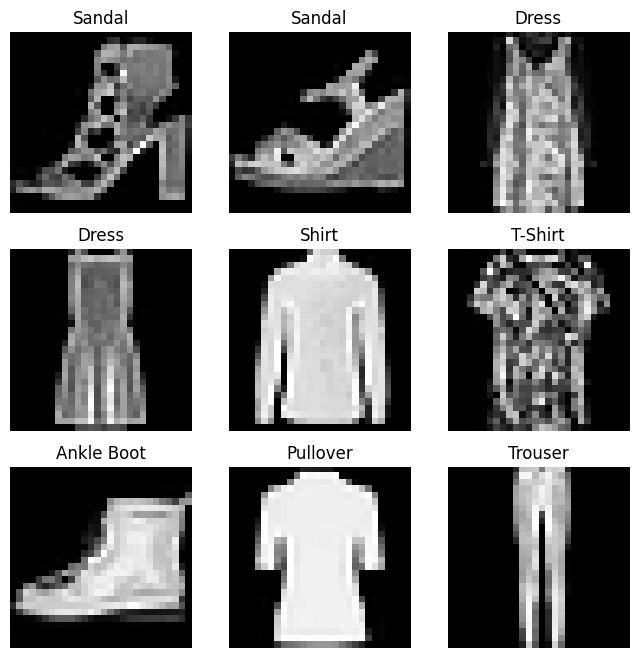

In [126]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [123]:
class PatchEmbedding(nn.Module):
    r"""
    Layer to take in the input image and do the following:
        1.  Transform grid of image into a sequence of patches.
            Number of patches are decided based on image height,width and
            patch height, width.
        2. Add cls token to the above created sequence of patches in the
            first position
        3. Add positional embedding to the above sequence(after adding cls)
        4. Dropout if needed
    """
    def __init__(self, config):
        super().__init__()
        # Example configuration
        #   Image c,h,w : 3, 224, 224
        #   Patch h,w : 16, 16
        image_height = config['image_height']
        image_width = config['image_width']
        im_channels = config['im_channels']
        emb_dim = config['emb_dim']
        patch_embd_drop = config['patch_emb_drop']
        
        self.patch_height = config['patch_height']
        self.patch_width = config['patch_width']
        
        # Compute number of patches for positional parameters initialization
        #   num_patches = num_patches_h * num_patches_w
        #   num_patches = 224/16 * 224/16
        #   num_patches = 196
        num_patches = (image_height // self.patch_height) * (image_width // self.patch_width)
        
        # This is the input dimension of the patch_embed layer
        # After patchifying the 224, 224, 3 image will be
        # num_patches x patch_h x patch_w x 3
        # Which will be 196 x 16 x 16 x 3
        # Hence patch dimension = 16 * 16 * 3
        patch_dim = im_channels * self.patch_height * self.patch_width
        
        self.patch_embed = nn.Sequential(
            # This pre and post layer norm speeds up convergence
            # Comment them if you want pure vit implementation
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, emb_dim),
            nn.LayerNorm(emb_dim)
        )
        
        # Positional information needs to be added to cls as well so 1+num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.randn(emb_dim))
        self.patch_emb_dropout = nn.Dropout(patch_embd_drop)      
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # This is doing the B, 3, 224, 224 -> (B, num_patches, patch_dim) transformation
        # B, 3, 224, 224 -> B, 3, 14*16, 14*16
        # B, 3, 14*16, 14*16 -> B, 3, 14, 16, 14, 16
        # B, 3, 14, 16, 14, 16 -> B, 14, 14, 16, 16, 3
        #  B, 14*14, 16*16*3 - > B, num_patches, patch_dim
        out = rearrange(x, 'b c (nh ph) (nw pw) -> b (nh nw) (ph pw c)',
                      ph=self.patch_height,
                      pw=self.patch_width)
        out = self.patch_embed(out)
        
        # Add cls
        cls_tokens = repeat(self.cls_token, 'd -> b 1 d', b=batch_size)
        out = torch.cat((cls_tokens, out), dim=1)
        
        # Add position embedding and do dropout
        out += self.pos_embed
        out = self.patch_emb_dropout(out)
        
        return out


In [170]:
class Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.n_heads=config['n_heads']
        self.head_dim=config['head_dim']
        self.emb_dim=config['emb_dim']
        self.drop_prob= config['dropout'] if 'dropout' in config else 0.0
        self.att_dim= self.n_heads* self.head_dim

        self.qkv_proj= nn.Linear(self.emb_dim, 3*self.att_dim,bias=False)
        self.output_proj= nn.Sequential(
            nn.Linear(self.att_dim,self.emb_dim),
            nn.Dropout(self.drop_prob)
        )
        self.attn_dropout= nn.Dropout(self.drop_prob)

    def forward(self,x):
        #Converting to attention dimension 
        #batch size x number patches x dimension
        B,N= x.shape[:2]
        #projecting to 3*att_dim and then splitting to get q,k,v (each of attention dimension)
        #qkv-> Batch Size x Number of patches x (3* Attention dimension)
        #q(as well as k and v)-> Batch Size x Number of Patches x Attention Dimension
        q,k,v= self.qkv_proj(x).split(self.att_dim,dim=-1)
        #Batch size  x number of patches x attention dimension
        # -> Batch size x number of patches x heads x head dimension
        q = rearrange(q, 'b n (n_h h_dim) -> b n_h n h_dim',
                      n_h=self.n_heads, h_dim=self.head_dim)
        k = rearrange(k, 'b n (n_h h_dim) -> b n_h n h_dim',
                      n_h=self.n_heads, h_dim=self.head_dim)
        v = rearrange(v, 'b n (n_h h_dim) -> b n_h n h_dim',
                      n_h=self.n_heads, h_dim=self.head_dim)

        #compute attention weights
        #B x H x N x  Head Dimension @ B x H x N x Head Dimension x N
        # -> B x H x N x N 
        att= torch.matmul(q,k.transpose(-2,-1)* (self.head_dim**(-0.5)))
        att= torch.nn.functional.softmax(att,dim=-1)
        arr = self.attn_dropout(att)
        # Weighted value computation
        #B x H x N x N  @ B x H x N x Head Dimension
        #-> B x H x N x Head Dimension
        out = torch.matmul(att,v)
        #converting to the transformer dimension 
        # B x N x Head Dimension x Heads -> Bx N x Attention Dimension
        out= rearrange(out, pattern= 'b n_h n h_dim -> b n (n_h h_dim)')
        # B x N x Dimension 
        out = self.output_proj(out)
        return out
        
        

In [171]:
class TransformerLayer(nn.Module):
    """
    Transformer block which is just doing the following
        1. LayerNorm followed by attention 
        2. LayerNorm followed by feed forward block 
        Both these also have residuals aded to them
    """
    def __init__(self,config):
        super().__init__()
        emb_dim = config['emb_dim']
        ff_hidden_dim= config['ff_hidden_dim'] if 'ff_hidden_dim' in config else 4* emb_dim
        ff_drop_prob= config['ff_drop'] if 'ff_drop' in config else 0.0
        self.att_norm= nn.LayerNorm(emb_dim)
        self.attn_block= Attention(config)
        self.ff_norm= nn.LayerNorm(emb_dim)
        self.ff_block= nn.Sequential(
            nn.Linear(emb_dim,ff_hidden_dim),
            nn.GELU(),
            nn.Dropout(ff_drop_prob),
            nn.Linear(ff_hidden_dim, emb_dim),
            nn.Dropout(ff_drop_prob)
        )
    def forward(self,x):
        out=x
        out = out + self.attn_block(self.att_norm(out))
        out= out + self.ff_block(self.ff_norm(out))
        return out
        

In [172]:
class VIT(nn.Module):
    def __init__(self,config):
        super().__init__()
        n_layers= config['n_layers']
        emb_dim= config['emb_dim']
        num_classes = config['num_classes']
        self.patch_embed_layer= PatchEmbedding(config)
        self.layers= nn.ModuleList(
            [TransformerLayer(config) for _ in range (n_layers)]
        )
        self.norm= nn.LayerNorm(emb_dim)
        self.fc_number= nn.Linear(emb_dim, num_classes)
    def forward(self,x):
        # Patchify and add the CLS token 
        out = self.patch_embed_layer(x)

        #Go through the transformer layers 
        for layer in self.layers:
            out=layer(out)
        out=self.norm(out)
        #compute logits
        return self.fc_number(out[:,0])

In [173]:
model_params = {
    'n_heads': 4,  
    'head_dim': 64,
    'emb_dim': 128,  
    'attn_drop': 0.1,
    'ff_dim': 512,  # Typically 4 * emb_dim
    'ff_drop': 0.1,
    'n_layers': 6,
    'bg_classes': 44,
    'num_classes': 10,
    'image_height': 28,
    'image_width': 28,
    'patch_height': 4,
    'patch_width': 4,
    'patch_emb_drop': 0.1,
    'im_channels': 1
}
train_params={
  'task_name': 'default',
  'batch_size': 64,
  'epochs': 100,
  'lr': 0.001,
  'seed': 1111,
  'ckpt_name': 'vit_ckpt.pth'
}
dataset_params={
  'root_dir': 'data'
}
    

In [174]:
train_dataloader= DataLoader(training_data,batch_size=train_params['batch_size'])
test_dataloader= DataLoader(test_data,batch_size=train_params['batch_size'])
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [175]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [176]:
model= VIT(model_params).to(device)
print(model)

VIT(
  (patch_embed_layer): PatchEmbedding(
    (patch_embed): Sequential(
      (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=16, out_features=128, bias=True)
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_emb_dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (att_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn_block): Attention(
        (qkv_proj): Linear(in_features=128, out_features=768, bias=False)
        (output_proj): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
        (attn_dropout): Dropout(p=0.0, inplace=False)
      )
      (ff_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff_block): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (

In [177]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(),lr=train_params['lr'])

In [178]:
def train(dataloader, model, loss_fn,optimizer):
    size= len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y= X.to(device) ,y.to(device)
        #compute the prediction error
        pred = model(X)
        loss= loss_fn(pred,y)

        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch %100 ==0:
            loss, current = loss.item(),(batch+1)* len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [179]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [180]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.358173  [   64/60000]
loss: 2.326109  [ 6464/60000]
loss: 2.321358  [12864/60000]
loss: 2.198322  [19264/60000]
loss: 2.215465  [25664/60000]
loss: 2.196453  [32064/60000]
loss: 2.079684  [38464/60000]
loss: 2.117659  [44864/60000]
loss: 2.153700  [51264/60000]
loss: 2.003454  [57664/60000]
Test Error: 
 Accuracy: 30.7%, Avg loss: 1.932768 

Epoch 2
-------------------------------
loss: 2.064945  [   64/60000]
loss: 2.015975  [ 6464/60000]
loss: 1.903547  [12864/60000]
loss: 1.939112  [19264/60000]
loss: 1.795083  [25664/60000]
loss: 1.842071  [32064/60000]
loss: 1.751491  [38464/60000]
loss: 1.786658  [44864/60000]
loss: 1.759342  [51264/60000]
loss: 1.542594  [57664/60000]
Test Error: 
 Accuracy: 43.3%, Avg loss: 1.516223 

Epoch 3
-------------------------------
loss: 1.745782  [   64/60000]
loss: 1.662416  [ 6464/60000]
loss: 1.456959  [12864/60000]
loss: 1.504004  [19264/60000]
loss: 1.422806  [25664/60000]
loss: 1.514937  [32064/600